<a href="https://colab.research.google.com/github/vrushabhmudda/Deep-Learning-project/blob/main/Last_EfficientNetV2B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ISIC 2024 — EfficientNetB0, EfficientNetV2B0



##Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
import zipfile
import os

# MARTA: creating path for dataset to unzip
!mkdir -p /content/isic_data

# MARTA: use own directory in code below....storing dataset in colab runtime due to lack of storage in google drive
!unzip -oq "/content/drive/MyDrive/Colab Notebooks/isic-2024-challenge.zip"  -d /content/isic_data

In [ ]:
# MARTA:
!ls /content/isic_data

sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


In [ ]:
import os
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd

# Create local working directories
!mkdir -p /content/data/processed
!mkdir -p /content/models
!mkdir -p /content/results

# Copy metadata CSV to local (small file, fast)
!cp /content/drive/MyDrive/ISIC2024/data/raw/train-metadata.csv /content/data/
!cp /content/drive/MyDrive/ISIC2024/data/raw/test-metadata.csv /content/data/

# Load images DIRECTLY from Drive, but save everything else locally
#train_image_dir = '/content/drive/MyDrive/ISIC2024/data/raw/train-image/image/'
#test_image_dir = '/content/drive/MyDrive/ISIC2024/data/raw/test-image/image/'
#test_image_dir = '/content/isic_data/test-image/image'
train_image_dir = '/content/isic_data/train-image/image'

#print("✓ Setup complete - reading images from Drive, saving work locally")


###Train Data

In [ ]:
# viewing file names
train_image_files = os.listdir(train_image_dir)
train_image_files = [os.path.splitext(f)[0] for f in train_image_files]

# Load metadata
train_df = pd.read_csv('/content/data/train-metadata.csv')

# making sure only matching IDs used
train_df = train_df[train_df['isic_id'].isin(train_image_files)]
train_df = train_df.sort_values('isic_id').reset_index(drop=True)

print(f"Total images: {len(train_image_files)}")
print(f"Matching labels: {len(train_df)}")

/tmp/ipython-input-171700884.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/data/train-metadata.csv')


Total images: 401059
Matching labels: 401059


###Test Data

In [ ]:
import os, h5py, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from io import BytesIO

TE_META_CSV = "/content/isic_data/test-metadata.csv"
TE_H5       = "/content/isic_data/test-image.hdf5"
OUT_DIR     = Path("/content/isic_data/test-image/image")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def decode_h5_image_to_pil(value):
    """
    Accepts: numeric ndarray (HWC or CHW or HW) OR bytes/byte-array.
    Returns: PIL.Image in RGB.
    """
    # Case 1: raw bytes or 0-dim ndarray of bytes
    if isinstance(value, (bytes, np.bytes_)):
        return Image.open(BytesIO(value)).convert("RGB")

    if isinstance(value, np.ndarray):
        # ndarray of bytes (e.g., dtype kind 'S'/'O') – flatten to a single bytes object
        if value.dtype.kind in ("S", "O"):
            # Many H5 files store a single bytes object in a 0-d array; handle both 0-d and 1-d
            if value.ndim == 0:
                b = bytes(value.tobytes())
            else:
                # join in case of 1-d array of bytes/fragments
                b = b"".join([bytes(x) for x in value.ravel()])
            return Image.open(BytesIO(b)).convert("RGB")

        # Case 2: numeric array with pixels
        arr = np.asarray(value)
        arr = np.squeeze(arr)

        # If channels-first (C,H,W), move to H,W,C
        if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[-1] not in (1, 3):
            arr = np.moveaxis(arr, 0, -1)

        # Grayscale → RGB
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        if arr.ndim == 3 and arr.shape[-1] == 1:
            arr = np.repeat(arr, 3, axis=-1)

        # Scale/convert to uint8
        if arr.dtype != np.uint8:
            a_min, a_max = float(np.nanmin(arr)), float(np.nanmax(arr))
            if a_max <= 1.5 and a_min >= -0.5:   # likely [0,1] or [-0.5,1.5]
                arr = np.clip(arr, 0, 1) * 255.0
            else:
                arr = np.clip(arr, 0, 255)
            arr = arr.astype(np.uint8)

        return Image.fromarray(arr, mode="RGB")

    # Fallback: try to coerce to bytes
    try:
        return Image.open(BytesIO(bytes(value))).convert("RGB")
    except Exception as e:
        raise TypeError(f"Unsupported H5 value type for image: {type(value)}") from e

# Load metadata
te_df = pd.read_csv(TE_META_CSV, low_memory=False)
wanted_ids = te_df["isic_id"].astype(str).tolist()

exported, missing = 0, []
with h5py.File(TE_H5, "r") as f:
    h5_ids = set(map(str, list(f.keys())))
    for isic in wanted_ids:
        if isic not in h5_ids:
            missing.append(isic); continue
        node = f[isic]

        # If each ID is a group, try common subkeys
        if isinstance(node, h5py.Group):
            img_value = None
            for cand in ["image", "img", "images", "X", "data", "arr"]:
                if cand in node:
                    img_value = node[cand][()]
                    break
            if img_value is None:
                # If group contains a single dataset with unknown name, take the first
                keys = list(node.keys())
                if keys:
                    img_value = node[keys[0]][()]
            if img_value is None:
                missing.append(isic); continue
        else:
            # Direct dataset
            img_value = node[()]

        try:
            pil_img = decode_h5_image_to_pil(img_value)
            pil_img.save(OUT_DIR / f"{isic}.jpg", quality=95)
            exported += 1
        except Exception as e:
            print(f"[WARN] Could not decode {isic}: {e}")
            missing.append(isic)

print(f"Exported {exported} JPGs to: {OUT_DIR}")
if missing:
    print(f"Missing/undecodable ({len(missing)}): {missing[:5]} ...")


Exported 3 JPGs to: /content/isic_data/test-image/image


Files: ['ISIC_0015740.jpg', 'ISIC_0015729.jpg', 'ISIC_0015657.jpg']


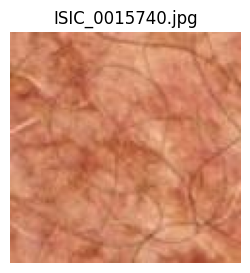

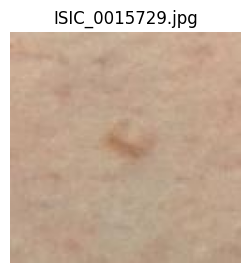

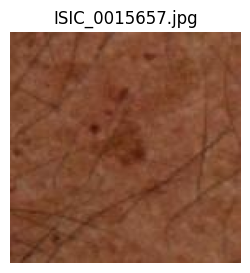

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

test_dir = "/content/isic_data/test-image/image"
files = os.listdir(test_dir)

print("Files:", files)

for fname in files:
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path)

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')


In [ ]:

#@title ⚙️ Setup & Config


import os, random, math, json, gc, sys
import numpy as np
import pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Optional focal loss (uncomment to use after installing TFA)
try:
    import tensorflow_addons as tfa
    HAS_TFA = True
except Exception:
    HAS_TFA = False

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# ==== Paths (EDIT THESE IF NEEDED) ====
# Training images dir (each image is {isic_id}.jpg) and train metadata CSV
TR_IMG_DIR = "/content/isic_data/train-image/image"  #@param {type:"string"}
TR_META_CSV = "/content/isic_data/train-metadata.csv"  #@param {type:"string"}

# Test images dir and metadata CSV (you may only have a few local test images)
TE_IMG_DIR = "/content/isic_data/test-image/image"  #@param {type:"string"}
TE_META_CSV = "/content/isic_data/test-metadata.csv"  #@param {type:"string"}

# ==== Training params ====
IMG_SIZE = 224  #@param {type:"integer"}
BATCH_SIZE = 32  #@param {type:"integer"}
INIT_EPOCHS = 3  # Freeze base
FINETUNE_EPOCHS = 7  # Unfreeze top layers
LR_BASE = 3e-4  #@param {type:"number"}
LR_FINETUNE = 1e-4  #@param {type:"number"}

# Imbalance handling
USE_FOCAL = False  #@param {type:"boolean"}
TARGET_POS_FRAC = 0.20  # used if oversampling is enabled
ENABLE_OVERSAMPLING = False  #@param {type:"boolean"}

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Mixed precision for faster training on recent GPUs
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("Using mixed precision:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)

# Enable XLA if available
tf.config.optimizer.set_jit(True)

# Output / checkpoints
OUT_DIR = Path("./out_isic")
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = OUT_DIR / "isic_efficientnetb0_best.keras"
MODEL_PATH2 = OUT_DIR / "isic_efficientnetv2b0_best.keras"
PRED_CSV = OUT_DIR / "predictions.csv"


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using mixed precision: <DTypePolicy "mixed_float16">


In [ ]:

#@title 📥 Load metadata & match to image files
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(TR_META_CSV, low_memory=False)
print("Train metadata rows:", len(train_df))
assert "isic_id" in train_df.columns, "train-metadata.csv must have 'isic_id'"
assert "target" in train_df.columns, "train-metadata.csv must have 'target' (0/1)"

# Only keep rows that have a corresponding image file
train_df["image_path"] = train_df["isic_id"].apply(lambda x: os.path.join(TR_IMG_DIR, f"{x}.jpg"))
train_df = train_df[train_df["image_path"].apply(os.path.exists)].copy()
train_df["target"] = train_df["target"].astype(int)

print("After matching to existing images:", len(train_df))

# Stratified split
train_df, val_df = train_test_split(
    train_df, test_size=0.15, random_state=SEED, stratify=train_df["target"]
)
print("Train size:", len(train_df), "| Val size:", len(val_df))
print("Positives in Train:", train_df['target'].sum(), "| Val:", val_df['target'].sum())


Train metadata rows: 401059
After matching to existing images: 401059
Train size: 340900 | Val size: 60159
Positives in Train: 334 | Val: 59


In [ ]:

#@title 🔄 Build tf.data pipelines (with optional oversampling)

AUTO = tf.data.AUTOTUNE

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # EfficientNet expects [0,255] then model's preprocess will scale internally
    return img

def preprocess(path, label):
    img = decode_img(path)
    return img, tf.cast(label, tf.int32)

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

def make_ds(df, training=True, oversample=False):
    paths = df["image_path"].values
    labels = df["target"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=min(len(df), 10000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)

    if training and oversample:
        # Separate pos/neg
        pos = df[df.target==1]
        neg = df[df.target==0]
        n_neg = len(neg)
        target_pos = int(TARGET_POS_FRAC * n_neg / (1 - TARGET_POS_FRAC))

        # Build datasets
        pos_ds = tf.data.Dataset.from_tensor_slices((pos["image_path"].values, pos["target"].values))
        pos_ds = pos_ds.repeat()  # repeat to allow sampling many times
        pos_ds = pos_ds.map(preprocess, num_parallel_calls=AUTO).map(augment, num_parallel_calls=AUTO)

        neg_ds = tf.data.Dataset.from_tensor_slices((neg["image_path"].values, neg["target"].values))
        neg_ds = neg_ds.map(preprocess, num_parallel_calls=AUTO).map(augment, num_parallel_calls=AUTO)

        # Interleave: take many positives and combine with negatives
        # We'll sample positives to reach TARGET_POS_FRAC approximately.
        pos_ds = pos_ds.take(max(target_pos, 1))
        base_ds = neg_ds.concatenate(pos_ds)

        ds = base_ds.shuffle(buffer_size=min(len(neg)+max(target_pos,1), 20000), seed=SEED)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

train_ds = make_ds(train_df, training=True, oversample=ENABLE_OVERSAMPLING)
val_ds   = make_ds(val_df,   training=False, oversample=False)


In [ ]:

#@title 🧠 Build EfficientNetB0 model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_model(trainable_base=False):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inp)  # scales to expected range
    base = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    base.trainable = trainable_base  # freeze or unfreeze later

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # force float32 for numeric stability

    model = keras.Model(inp, out)
    return model

model = build_model(trainable_base=False)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:

#@title ⚖️ Compile (Class Weights + optional Focal Loss)
METRICS = [
    keras.metrics.AUC(name="auc", curve="ROC"),
    keras.metrics.AUC(name="pr_auc", curve="PR"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

if USE_FOCAL and HAS_TFA:
    print("Using focal loss (binary_focal_crossentropy).")
    loss_fn = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
else:
    print("Using standard binary crossentropy.")
    loss_fn = keras.losses.BinaryCrossentropy()

opt = keras.optimizers.Adam(learning_rate=LR_BASE)
model.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)

# Compute class weights from training split
neg = int((train_df["target"]==0).sum())
pos = int((train_df["target"]==1).sum())
cw = {0: 1.0, 1: max(1.0, neg / max(pos, 1))}
print("Class weights:", cw)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=str(MODEL_PATH), monitor="val_auc",
                                    mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5,
                                      patience=2, min_lr=1e-6, verbose=1),
]


Using standard binary crossentropy.
Class weights: {0: 1.0, 1: 1019.6586826347306}


In [ ]:

#@title 🥶 Phase 1: Train with base frozen
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INIT_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    verbose=1
)


Epoch 1/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 636s 54ms/step - auc: 0.6659 - loss: 1.3451 - pr_auc: 0.0047 - precision: 0.0020 - recall: 0.5067 - val_auc: 0.8255 - val_loss: 0.5111 - val_pr_auc: 0.0426 - val_precision: 0.0036 - val_recall: 0.7458
Epoch 2/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 431s 40ms/step - auc: 0.8077 - loss: 1.0769 - pr_auc: 0.0205 - precision: 0.0033 - recall: 0.6772 - val_auc: 0.8485 - val_loss: 0.5362 - val_pr_auc: 0.0358 - val_precision: 0.0034 - val_recall: 0.7966
Epoch 3/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 456s 43ms/step - auc: 0.8240 - loss: 1.0530 - pr_auc: 0.0148 - precision: 0.0034 - recall: 0.7282 - val_auc: 0.8572 - val_loss: 0.3464 - val_pr_auc: 0.0429 - val_precision: 0.0058 - val_recall: 0.6271


In [ ]:

#@title 🔓 Phase 2: Unfreeze top layers and fine-tune
# Unfreeze last N blocks for a gentle fine-tune
for layer in model.layers:
    if "block6" in layer.name or "block7" in layer.name:
        layer.trainable = True

# Recompile with lower LR
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
              loss=loss_fn, metrics=METRICS)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    callbacks=callbacks,
    verbose=1
)
print("Best model saved to:", MODEL_PATH)


Epoch 1/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8136 - loss: 1.6510 - pr_auc: 0.0191 - precision: 0.0039 - recall: 0.6580
Epoch 1: val_auc improved from -inf to 0.89495, saving model to out_isic/isic_efficientnetb0_best.keras
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 689s 57ms/step - auc: 0.8136 - loss: 1.6509 - pr_auc: 0.0191 - precision: 0.0039 - recall: 0.6580 - val_auc: 0.8950 - val_loss: 0.3373 - val_pr_auc: 0.0357 - val_precision: 0.0076 - val_recall: 0.7797 - learning_rate: 1.0000e-04
Epoch 2/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8720 - loss: 1.0441 - pr_auc: 0.0229 - precision: 0.0051 - recall: 0.7740
Epoch 2: val_auc did not improve from 0.89495
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 475s 45ms/step - auc: 0.8720 - loss: 1.0441 - pr_auc: 0.0229 - precision: 0.0051 - recall: 0.7740 - val_auc: 0.8459 - val_loss: 0.1586 - val_pr_auc: 0.0451 - val_precision: 0.0139 - val_recall: 0.5424 - learning_rate: 1.0000e-04
Epoch 3/7
10653/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 42

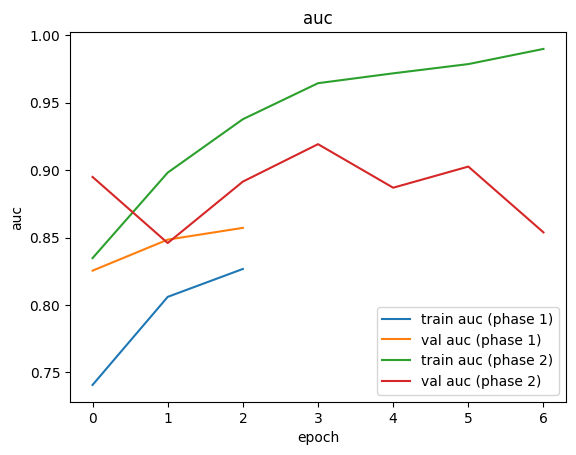

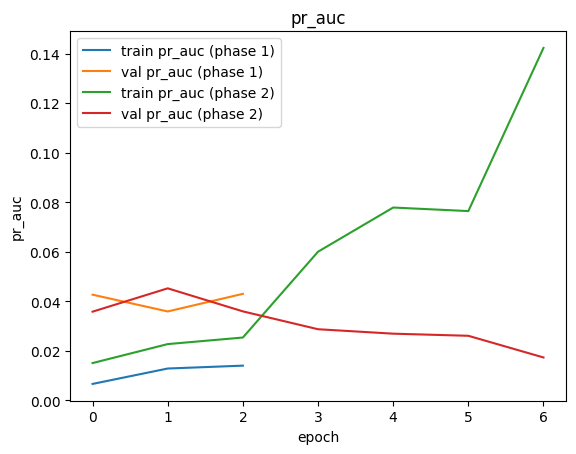

Val ROC AUC: 0.9271241433768578


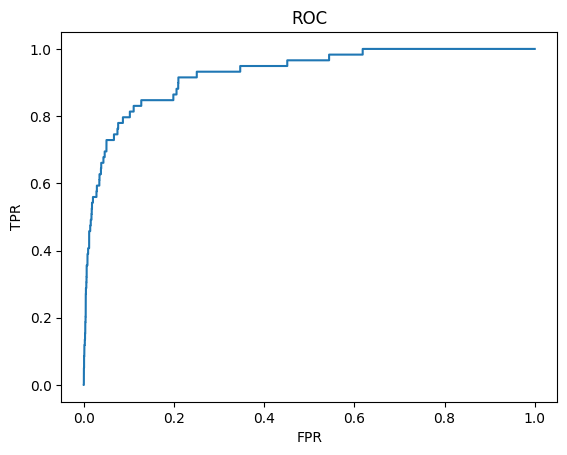

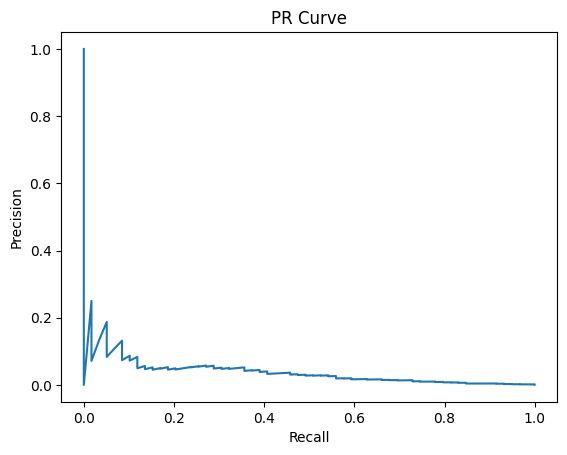

Threshold: 0.3
Confusion matrix (tn, fp; fn, tp):
 [[53778  6322]
 [   11    48]]


In [ ]:

#@title 📈 Curves & Validation Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix

def plot_history(histories, key="auc"):
    plt.figure()
    for i, h in enumerate(histories, start=1):
        if h is None: continue
        plt.plot(h.history.get(key, []), label=f"train {key} (phase {i})")
        plt.plot(h.history.get(f"val_{key}", []), label=f"val {key} (phase {i})")
    plt.xlabel("epoch"); plt.ylabel(key); plt.legend(); plt.title(key); plt.show()

plot_history([history1, history2], key="auc")
plot_history([history1, history2], key="pr_auc")

# Collect validation predictions for detailed metrics
val_paths = val_df["image_path"].values
val_labels = val_df["target"].values
val_ds_eval = tf.data.Dataset.from_tensor_slices(val_paths).map(decode_img).batch(BATCH_SIZE)
val_preds = model.predict(val_ds_eval, verbose=0).ravel()

roc_auc = roc_auc_score(val_labels, val_preds)
print("Val ROC AUC:", roc_auc)

# ROC curve
fpr, tpr, th = roc_curve(val_labels, val_preds)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()

# PR curve
prec, rec, thr = precision_recall_curve(val_labels, val_preds)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.show()

# Pick a threshold that gets reasonable recall (e.g., 0.30)
thr_choice = 0.30
pred_bin = (val_preds >= thr_choice).astype(int)
cm = confusion_matrix(val_labels, pred_bin)
print("Threshold:", thr_choice)
print("Confusion matrix (tn, fp; fn, tp):\n", cm)


In [ ]:

#@title 📤 Inference on Test & Export CSV
if os.path.exists(TE_META_CSV) and os.path.exists(TE_IMG_DIR):
    te_df = pd.read_csv(TE_META_CSV, low_memory=False)
    assert "isic_id" in te_df.columns, "test-metadata.csv must have 'isic_id'"
    te_df["image_path"] = te_df["isic_id"].apply(lambda x: os.path.join(TE_IMG_DIR, f"{x}.jpg"))
    te_df = te_df[te_df["image_path"].apply(os.path.exists)].copy()
    print("Test images found:", len(te_df))

    # Load best model
    best = keras.models.load_model(MODEL_PATH, compile=False)
    # Reattach sigmoid if needed (already included)
    te_ds = tf.data.Dataset.from_tensor_slices(te_df["image_path"].values)\
            .map(decode_img).batch(BATCH_SIZE)
    te_preds = best.predict(te_ds, verbose=0).ravel()
    out = pd.DataFrame({"isic_id": te_df["isic_id"].values, "target": te_preds})
    out.to_csv(PRED_CSV, index=False)
    print("Saved predictions to:", PRED_CSV)
else:
    print("Test metadata/dir not found — skipping test prediction.")



## 💡 Colab Compute Tips (to stretch your units)
- Train at **224×224**, only bump to 256 if you have time.
- Use **mixed precision** (already enabled) and **XLA**.
- Keep **batch size 32**; if OOM, drop to 16.
- Limit total epochs; the **early stopping + ReduceLROnPlateau** here avoids wasted cycles.
- Prototype with **small negative subset** (already controlled by class weights), then scale.
- Avoid long K-fold runs; **one strong split** + clear rationale is enough for a course project.



### Appendix: When to flip these toggles
- **`USE_FOCAL=True`** if you want the loss to emphasize hard positive examples.
- **`ENABLE_OVERSAMPLING=True`** if class weights aren’t enough; this increases positive frequency (and training time).  
  Use **either** class weights **or** oversampling — combining both can overcompensate.


#--Model 2--

##🧠 Build EfficientNetV2B0 model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def build_model(trainable_base=False):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inp)  # EfficientNetV2 preprocessing
    base = EfficientNetV2B0(
        include_top=False,
        input_tensor=x,
        weights="imagenet"
    )

    base.trainable = trainable_base  # freeze/unfreeze phases

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = keras.Model(inp, out)
    return model

model = build_model(trainable_base=False)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:

#@title ⚖️ Compile (Class Weights + optional Focal Loss)
METRICS = [
    keras.metrics.AUC(name="auc", curve="ROC"),
    keras.metrics.AUC(name="pr_auc", curve="PR"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

if USE_FOCAL and HAS_TFA:
    print("Using focal loss (binary_focal_crossentropy).")
    loss_fn = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
else:
    print("Using standard binary crossentropy.")
    loss_fn = keras.losses.BinaryCrossentropy()

opt = keras.optimizers.Adam(learning_rate=LR_BASE)
model.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)

# Compute class weights from training split
neg = int((train_df["target"]==0).sum())
pos = int((train_df["target"]==1).sum())
cw = {0: 1.0, 1: max(1.0, neg / max(pos, 1))}
print("Class weights:", cw)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=str(MODEL_PATH2), monitor="val_auc",
                                    mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5,
                                      patience=2, min_lr=1e-6, verbose=1),
]


Using standard binary crossentropy.
Class weights: {0: 1.0, 1: 1019.6586826347306}


In [ ]:

#@title 🥶 Phase 1: Train with base frozen
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INIT_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    verbose=1
)


Epoch 1/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 659s 57ms/step - auc: 0.6741 - loss: 1.3228 - pr_auc: 0.0063 - precision: 0.0018 - recall: 0.4774 - val_auc: 0.8433 - val_loss: 0.5475 - val_pr_auc: 0.0358 - val_precision: 0.0032 - val_recall: 0.7627
Epoch 2/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 506s 48ms/step - auc: 0.7853 - loss: 1.1310 - pr_auc: 0.0157 - precision: 0.0028 - recall: 0.6474 - val_auc: 0.8654 - val_loss: 0.4351 - val_pr_auc: 0.0354 - val_precision: 0.0046 - val_recall: 0.7119
Epoch 3/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 497s 47ms/step - auc: 0.8025 - loss: 1.0990 - pr_auc: 0.0169 - precision: 0.0031 - recall: 0.6809 - val_auc: 0.8671 - val_loss: 0.3567 - val_pr_auc: 0.0372 - val_precision: 0.0057 - val_recall: 0.6271


In [ ]:

#@title 🔓 Phase 2: Unfreeze top layers and fine-tune
# Unfreeze last N blocks for a gentle fine-tune
for layer in model.layers:
    if "block6" in layer.name or "block7" in layer.name:
        layer.trainable = True

# Recompile with lower LR
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
              loss=loss_fn, metrics=METRICS)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    callbacks=callbacks,
    verbose=1
)
print("Best model saved to:", MODEL_PATH2)


Epoch 1/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.8009 - loss: 1.8502 - pr_auc: 0.0176 - precision: 0.0036 - recall: 0.6456
Epoch 1: val_auc improved from -inf to 0.91506, saving model to out_isic/isic_efficientnetb0_best.keras
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 712s 58ms/step - auc: 0.8009 - loss: 1.8502 - pr_auc: 0.0176 - precision: 0.0036 - recall: 0.6456 - val_auc: 0.9151 - val_loss: 0.2240 - val_pr_auc: 0.0511 - val_precision: 0.0089 - val_recall: 0.6949 - learning_rate: 1.0000e-04
Epoch 2/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8936 - loss: 0.9684 - pr_auc: 0.0213 - precision: 0.0053 - recall: 0.7769
Epoch 2: val_auc did not improve from 0.91506
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 545s 51ms/step - auc: 0.8936 - loss: 0.9684 - pr_auc: 0.0213 - precision: 0.0053 - recall: 0.7769 - val_auc: 0.9030 - val_loss: 0.1898 - val_pr_auc: 0.0304 - val_precision: 0.0110 - val_recall: 0.6949 - learning_rate: 1.0000e-04
Epoch 3/7
10652/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 46

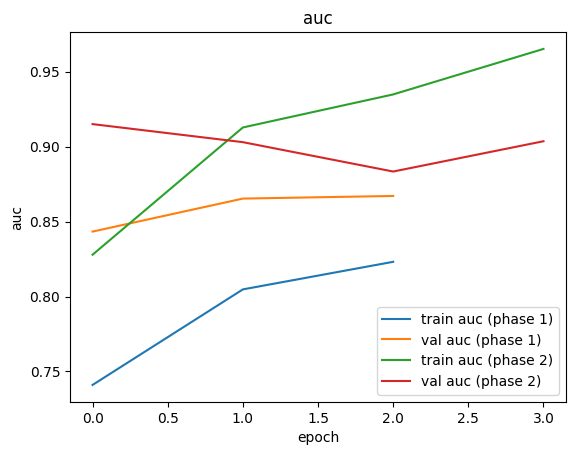

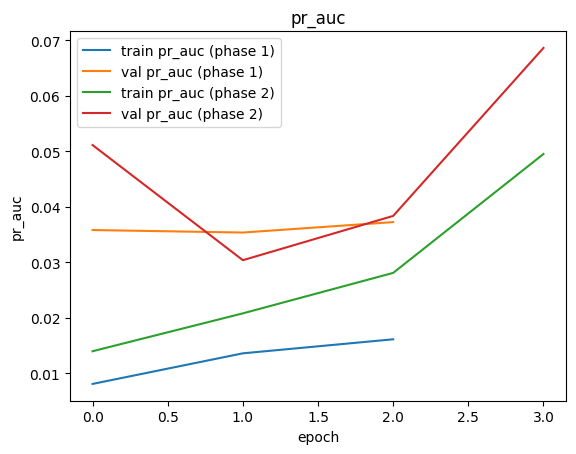

Val ROC AUC: 0.9172785470543445


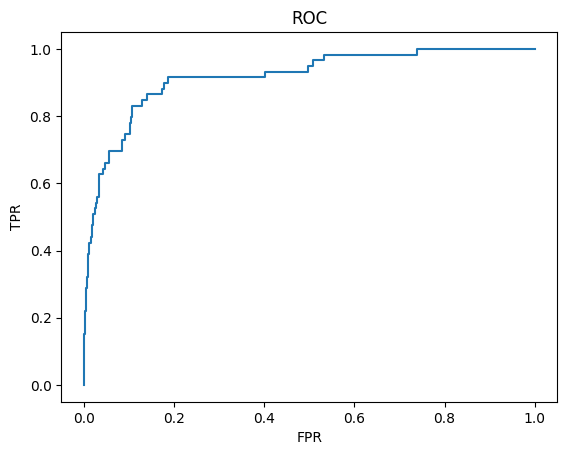

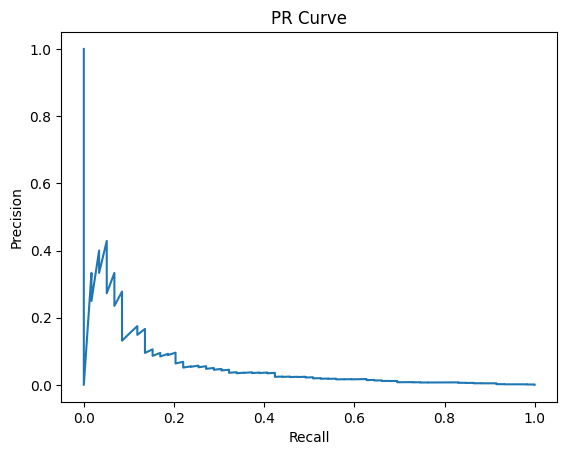

Threshold: 0.3
Confusion matrix (tn, fp; fn, tp):
 [[50197  9903]
 [    8    51]]


In [ ]:

#@title 📈 Curves & Validation Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix

def plot_history(histories, key="auc"):
    plt.figure()
    for i, h in enumerate(histories, start=1):
        if h is None: continue
        plt.plot(h.history.get(key, []), label=f"train {key} (phase {i})")
        plt.plot(h.history.get(f"val_{key}", []), label=f"val {key} (phase {i})")
    plt.xlabel("epoch"); plt.ylabel(key); plt.legend(); plt.title(key); plt.show()

plot_history([history1, history2], key="auc")
plot_history([history1, history2], key="pr_auc")

# Collect validation predictions for detailed metrics
val_paths = val_df["image_path"].values
val_labels = val_df["target"].values
val_ds_eval = tf.data.Dataset.from_tensor_slices(val_paths).map(decode_img).batch(BATCH_SIZE)
val_preds = model.predict(val_ds_eval, verbose=0).ravel()

roc_auc = roc_auc_score(val_labels, val_preds)
print("Val ROC AUC:", roc_auc)

# ROC curve
fpr, tpr, th = roc_curve(val_labels, val_preds)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()

# PR curve
prec, rec, thr = precision_recall_curve(val_labels, val_preds)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.show()

# Pick a threshold that gets reasonable recall (e.g., 0.30)
thr_choice = 0.30
pred_bin = (val_preds >= thr_choice).astype(int)
cm = confusion_matrix(val_labels, pred_bin)
print("Threshold:", thr_choice)
print("Confusion matrix (tn, fp; fn, tp):\n", cm)


In [ ]:

#@title 📤 Inference on Test & Export CSV
if os.path.exists(TE_META_CSV) and os.path.exists(TE_IMG_DIR):
    te_df = pd.read_csv(TE_META_CSV, low_memory=False)
    assert "isic_id" in te_df.columns, "test-metadata.csv must have 'isic_id'"
    te_df["image_path"] = te_df["isic_id"].apply(lambda x: os.path.join(TE_IMG_DIR, f"{x}.jpg"))
    te_df = te_df[te_df["image_path"].apply(os.path.exists)].copy()
    print("Test images found:", len(te_df))

    # Load best model
    best = keras.models.load_model(MODEL_PATH2, compile=False)
    # Reattach sigmoid if needed (already included)
    te_ds = tf.data.Dataset.from_tensor_slices(te_df["image_path"].values)\
            .map(decode_img).batch(BATCH_SIZE)
    te_preds = best.predict(te_ds, verbose=0).ravel()
    out = pd.DataFrame({"isic_id": te_df["isic_id"].values, "target": te_preds})
    out.to_csv(PRED_CSV, index=False)
    print("Saved predictions to:", PRED_CSV)
else:
    print("Test metadata/dir not found — skipping test prediction.")


Test images found: 3
Saved predictions to: out_isic/predictions.csv


#--Model 3--

###🧠 Build EfficientNetV2B0 model
Small Tweak on EfficientNetV2B0 (Checkpoint on PR-AUC)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def build_model(trainable_base=False):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inp)  # EfficientNetV2 preprocessing
    base = EfficientNetV2B0(
        include_top=False,
        input_tensor=x,
        weights="imagenet"
    )

    base.trainable = trainable_base  # freeze/unfreeze phases

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = keras.Model(inp, out)
    return model

model = build_model(trainable_base=False)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:

#@title ⚖️ Compile (Class Weights + optional Focal Loss)
METRICS = [
    keras.metrics.AUC(name="auc", curve="ROC"),
    keras.metrics.AUC(name="pr_auc", curve="PR"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

if USE_FOCAL and HAS_TFA:
    print("Using focal loss (binary_focal_crossentropy).")
    loss_fn = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
else:
    print("Using standard binary crossentropy.")
    loss_fn = keras.losses.BinaryCrossentropy()

opt = keras.optimizers.Adam(learning_rate=LR_BASE)
model.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)

# Compute class weights from training split
neg = int((train_df["target"]==0).sum())
pos = int((train_df["target"]==1).sum())
cw = {0: 1.0, 1: max(1.0, neg / max(pos, 1))}
print("Class weights:", cw)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="out_isic/isic_effnetb0_best_roc.keras",
        monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.ModelCheckpoint(
        filepath="out_isic/isic_effnetb0_best_pr.keras",
        monitor="val_pr_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                  patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max",
                                      factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

Using standard binary crossentropy.
Class weights: {0: 1.0, 1: 1019.6586826347306}


In [ ]:

#@title 🥶 Phase 1: Train with base frozen
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INIT_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    verbose=1
)


Epoch 1/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 620s 53ms/step - auc: 0.6755 - loss: 1.3234 - pr_auc: 0.0062 - precision: 0.0018 - recall: 0.4764 - val_auc: 0.8420 - val_loss: 0.5514 - val_pr_auc: 0.0361 - val_precision: 0.0031 - val_recall: 0.7627
Epoch 2/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 439s 41ms/step - auc: 0.7858 - loss: 1.1311 - pr_auc: 0.0169 - precision: 0.0027 - recall: 0.6341 - val_auc: 0.8650 - val_loss: 0.4420 - val_pr_auc: 0.0360 - val_precision: 0.0045 - val_recall: 0.7288
Epoch 3/3
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 430s 40ms/step - auc: 0.8004 - loss: 1.1043 - pr_auc: 0.0168 - precision: 0.0031 - recall: 0.6878 - val_auc: 0.8684 - val_loss: 0.3568 - val_pr_auc: 0.0371 - val_precision: 0.0058 - val_recall: 0.6271


In [ ]:

#@title 🔓 Phase 2: Unfreeze top layers and fine-tune
# Unfreeze last N blocks for a gentle fine-tune
for layer in model.layers:
    if "block6" in layer.name or "block7" in layer.name:
        layer.trainable = True

# Recompile with lower LR
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
              loss=loss_fn, metrics=METRICS)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    class_weight=None if ENABLE_OVERSAMPLING else cw,
    callbacks=callbacks,
    verbose=1
)
print("Best model saved to:", MODEL_PATH)


Epoch 1/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7998 - loss: 1.8589 - pr_auc: 0.0181 - precision: 0.0035 - recall: 0.6409
Epoch 1: val_auc improved from -inf to 0.91803, saving model to out_isic/isic_effnetb0_best_roc.keras

Epoch 1: val_pr_auc improved from -inf to 0.04550, saving model to out_isic/isic_effnetb0_best_pr.keras
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 666s 55ms/step - auc: 0.7998 - loss: 1.8589 - pr_auc: 0.0181 - precision: 0.0035 - recall: 0.6409 - val_auc: 0.9180 - val_loss: 0.2559 - val_pr_auc: 0.0455 - val_precision: 0.0089 - val_recall: 0.7966 - learning_rate: 1.0000e-04
Epoch 2/7
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8983 - loss: 0.9425 - pr_auc: 0.0213 - precision: 0.0055 - recall: 0.8251
Epoch 2: val_auc did not improve from 0.91803

Epoch 2: val_pr_auc did not improve from 0.04550
10654/10654 ━━━━━━━━━━━━━━━━━━━━ 539s 47ms/step - auc: 0.8983 - loss: 0.9425 - pr_auc: 0.0213 - precision: 0.0055 - recall: 0.8251 - val_auc: 0.9074 - val_lo

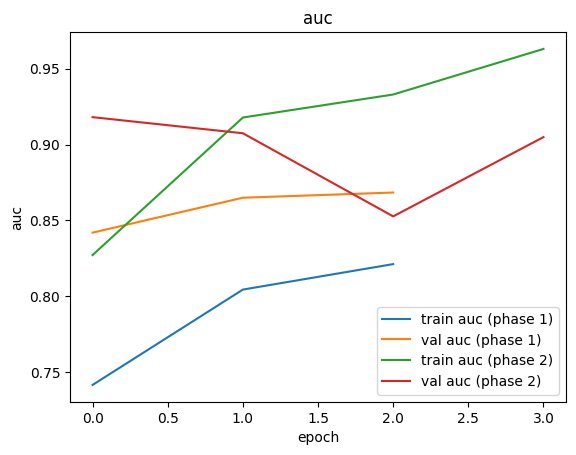

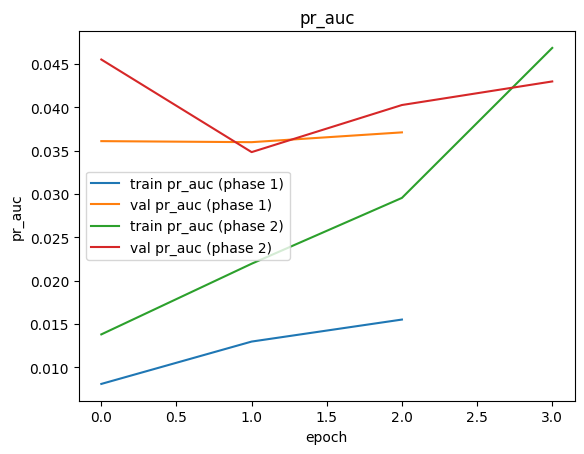

Val ROC AUC: 0.9189291858202431


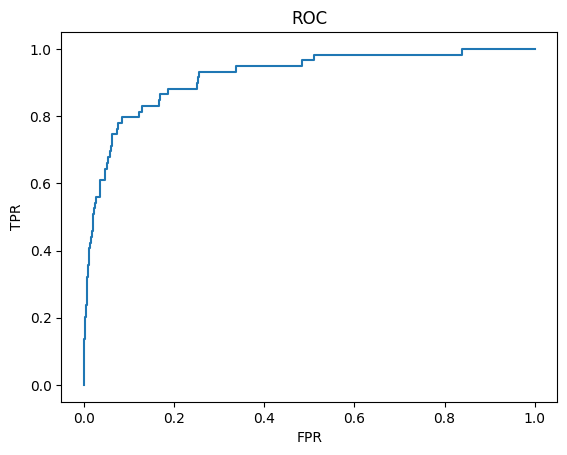

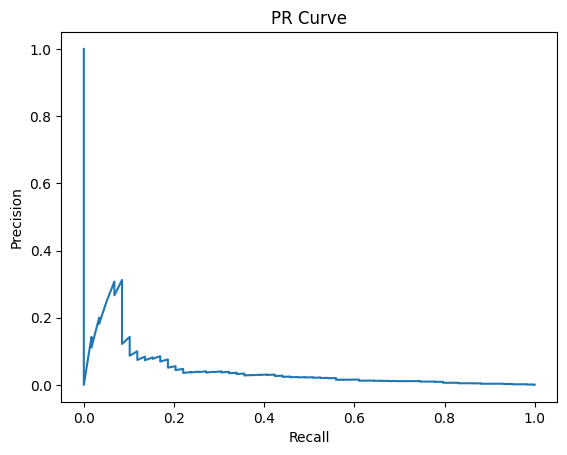

Threshold: 0.3
Confusion matrix (tn, fp; fn, tp):
 [[47773 12327]
 [    7    52]]


In [ ]:

#@title 📈 Curves & Validation Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix

def plot_history(histories, key="auc"):
    plt.figure()
    for i, h in enumerate(histories, start=1):
        if h is None: continue
        plt.plot(h.history.get(key, []), label=f"train {key} (phase {i})")
        plt.plot(h.history.get(f"val_{key}", []), label=f"val {key} (phase {i})")
    plt.xlabel("epoch"); plt.ylabel(key); plt.legend(); plt.title(key); plt.show()

plot_history([history1, history2], key="auc")
plot_history([history1, history2], key="pr_auc")

# Collect validation predictions for detailed metrics
val_paths = val_df["image_path"].values
val_labels = val_df["target"].values
val_ds_eval = tf.data.Dataset.from_tensor_slices(val_paths).map(decode_img).batch(BATCH_SIZE)
val_preds = model.predict(val_ds_eval, verbose=0).ravel()

roc_auc = roc_auc_score(val_labels, val_preds)
print("Val ROC AUC:", roc_auc)

# ROC curve
fpr, tpr, th = roc_curve(val_labels, val_preds)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()

# PR curve
prec, rec, thr = precision_recall_curve(val_labels, val_preds)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.show()

# Pick a threshold that gets reasonable recall (e.g., 0.30)
thr_choice = 0.30
pred_bin = (val_preds >= thr_choice).astype(int)
cm = confusion_matrix(val_labels, pred_bin)
print("Threshold:", thr_choice)
print("Confusion matrix (tn, fp; fn, tp):\n", cm)


In [ ]:

#@title 📤 Inference on Test & Export CSV
# Use absolute path to avoid CWD issues
MODEL_PATH = "/content/out_isic/isic_effnetb0_best_pr.keras"
PRED_CSV   = "/content/out_isic/predictions_effnetb0_bestPR.csv"

best = keras.models.load_model(MODEL_PATH, compile=False)

te_ds = tf.data.Dataset.from_tensor_slices(te_df["image_path"].values)\
        .map(decode_img).batch(BATCH_SIZE)

te_preds = best.predict(te_ds, verbose=0).ravel()
out = pd.DataFrame({"isic_id": te_df["isic_id"].values, "target": te_preds})
out.to_csv(PRED_CSV, index=False)
print("Saved predictions to:", PRED_CSV)



Saved predictions to: /content/out_isic/predictions_effnetb0_bestPR.csv
